## Part 1: Various plots using presupernova model: Odrzywolek 2010
Plots are from FluxContainer_demo.ipynb

In [1]:
import numpy as np
from astropy import units as u
from snewpy.models import presn, ccsn
from snewpy.neutrino import Flavor

import pylab as plt
from contextlib import contextmanager
plt.style.use('seaborn-talk')

/var/folders/4t/p2_knw3504lbc90bf1vzj4h00000gn/T/ipykernel_26174/2834227578.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [2]:
@contextmanager
def raises(exception):
    "A small utility to catch and show the exceptions"
    try:
        yield
    except exception as e:
        print(f'{exception.__name__}: {e}')

### Initializing model

In [3]:
model = presn.Odrzywolek_2010('../../models/presn-models/Odrzywolek_2010/s25_nuebar_data.txt')

times    = model.time #np.linspace(0,2,1500)<<u.second;
energies = np.linspace(0,50,501)<<u.MeV

flux = model.get_flux(t = times, E = energies, distance=0.6<<u.kpc)

In [4]:
from snewpy.flux import Container

Container?

Init signature:
Container(
    data: astropy.units.quantity.Quantity,
    flavor: List[snewpy.neutrino.Flavor],
    time: typing.Annotated[astropy.units.quantity.Quantity, Unit("s")],
    energy: typing.Annotated[astropy.units.quantity.Quantity, Unit("MeV")],
    *,
    integrable_axes: Optional[Set[snewpy.flux.Axes]] = None,
)
Docstring:     
base class for internal use
:noindex:
Init docstring:
A container class storing the physical quantity (flux, fluence, rate...), which depends on flavor, time and energy.

Parameters
----------
data: :class:`astropy.Quantity`
    3D array of the stored quantity, must have dimensions compatible with (flavor, time, energy)

flavor: list of :class:`snewpy.neutrino.Flavor`
    array of flavors (should be ``len(flavor)==data.shape[0]``

time: array of :class:`astropy.Quantity`
    sampling points in time (then ``len(time)==data.shape[1]``) 
    or time bin edges (then ``len(time)==data.shape[1]+1``) 

energy: array of :class:`astropy.Quantity`
    samp

### Calculate rates

In [5]:
from snewpy.rate_calculator import RateCalculator
rc = RateCalculator()

Using snowglobes_data module ...


In [6]:
#calculate time differential rate 
rates = rc.run(flux, 'scint20kt')
rates['ibd']

/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:42: RuntimeWarning: divide by zero encountered in log
  xsecs = np.interp(np.log(E)/np.log(10), xp, yp, left=0, right=0)*E*1e-38 <<u.cm**2
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channe

dNdT (1, 1034, 200) [1 / s]: <1 flavor(2;2) x 1034 time(-682922300000.0 s;-0.0 s) x 201 energy(0.25 MeV;100.25 MeV)>

In [7]:
#calculate time integral rate 
fluence = flux.integrate('time', np.arange(-172800,0,172.8)<<u.s) #Ida:changed the time in array
ratesI = rc.run(fluence, 'scint20kt')
ratesI['ibd']

N (1, 999, 200) []: <1 flavor(2;2) x 1000 time(-172800.0 s;-172.8000000116299 s) x 201 energy(0.25 MeV;100.25 MeV)>

In [8]:
#Utility function to draw the flux
from snewpy.flux import Axes

def project(flux, axis, integrate=True):
    axis = Axes[axis] #convert to enum
    integrate_axis = Axes.time 
    if axis == integrate_axis:
        integrate_axis = Axes.energy 
    fI = (flux.integrate if integrate else flux.sum)(integrate_axis)
    return fI.axes[axis], fI
    
def plot_projection(flux, axis, step=False, integrate=True):
    x,fI = project(flux,axis, integrate)
    y = fI.array.squeeze().T
    if step:
        #we're dealing with bins, not points
        l = plt.step(x[:-1], y, where='pre', label=[Flavor(flv).to_tex() for flv in flux.flavor])
    else:
        l = plt.plot(x, y, label=[Flavor(flv).to_tex() for flv in flux.flavor])
    
    plt.ylabel(f'{fI.__class__.__name__},  {y.unit}')
    plt.xlabel(f'{Axes[axis].name},  {x.unit}')
    return l

In [9]:
#Utility function to draw the 
def plot_rates(rates):
    for ch,r in rates.items():
        rT = r.sum('energy')

        plt.plot(rT.time, rT.array.squeeze(), label=ch)
    #plt.xlim(right=0.5)
    plt.ylabel(f'{rT.__class__.__name__},  {r.array.unit}')
    plt.xlabel(f'time, {rT.time.unit}')

### Plot fluxes

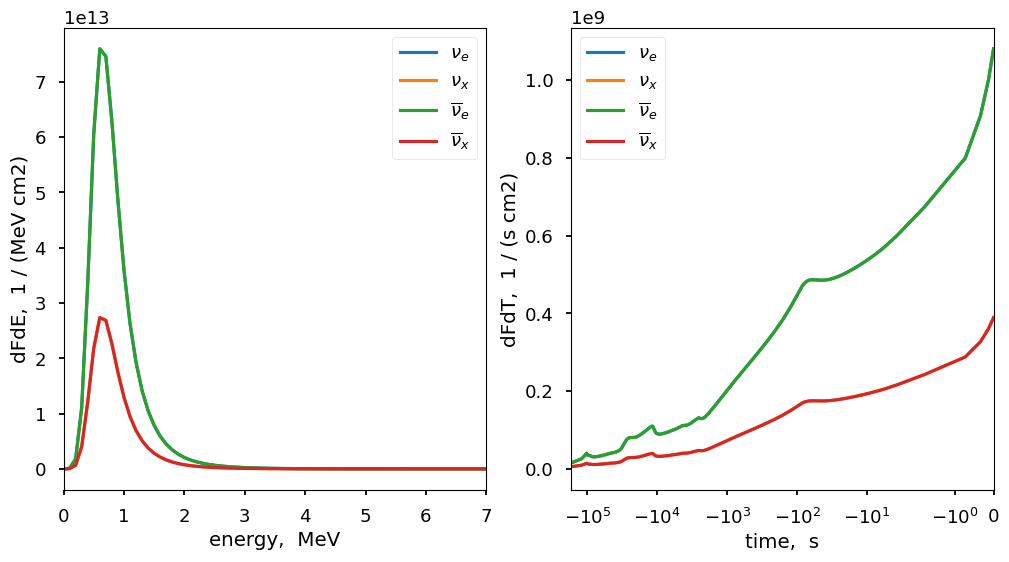

In [10]:
#plot the neutrino flux 
fig,ax = plt.subplots(1,2, figsize=(12,6))
plt.sca(ax[0])
plot_projection(flux, 'energy', integrate=True) #flux [:,1600:,:51]
plt.xlim(0,7) #ida added
plt.legend()

plt.sca(ax[1])
plot_projection(flux, 'time', integrate=True)
plt.xlim(-172000,0) #48 hours
plt.legend()
plt.xscale('symlog')
plt.show()

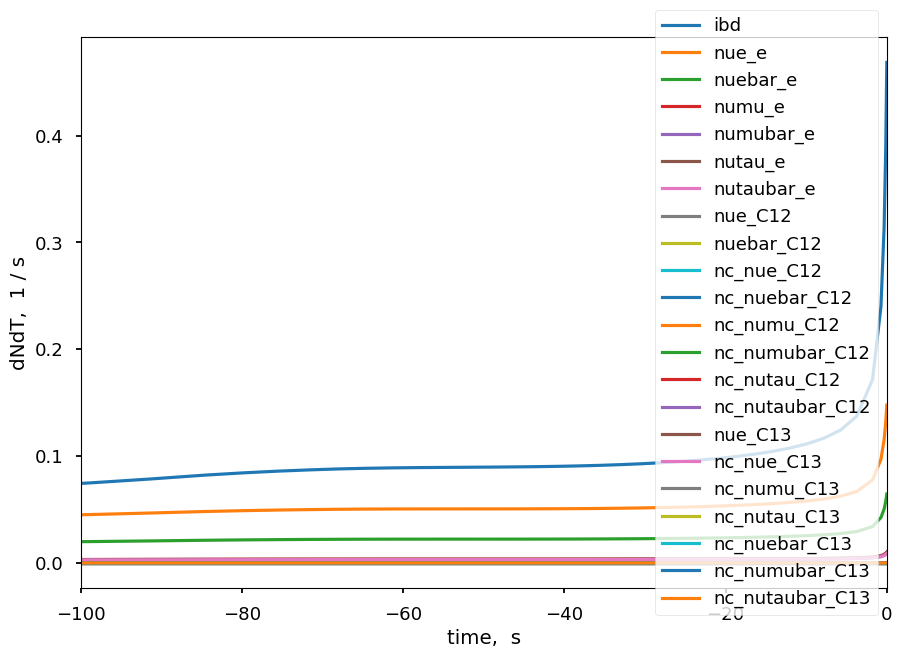

In [11]:
for ch, rate in rates.items():
    l = plot_projection(rate, 'time', integrate=False)
    l[0].set_label(ch)
#plt.yscale('log')
plt.legend(loc='right')
#plt.ylim(0.1)
plt.xlim(-100,0)
plt.show()

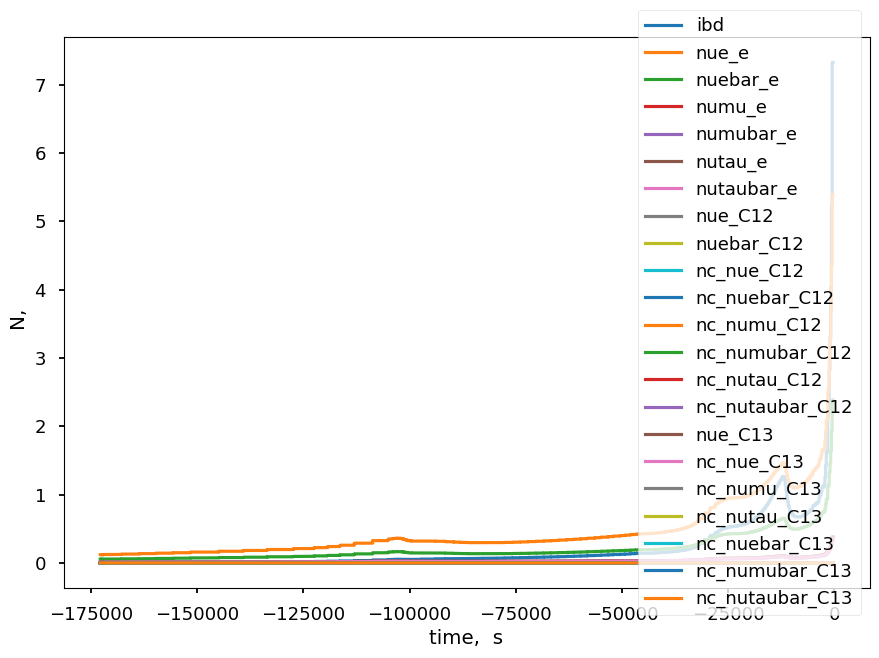

In [12]:
for ch, rate in ratesI.items():
    l = plot_projection(rate, 'time', integrate=False, step=True)
    l[0].set_label(ch)
#plt.yscale('log')
plt.legend(loc='right')
plt.show()

## Part 2: Reproducing plots from KamLAND paper
DOI 10.3847/0004-637X/818/1/91

### #1 Plot Fig. 2 (top) from KamLAND paper - PreSN luminosity 48 hours before collapse
Description: Time evolution (48 h) of electron anti-neutrino luminosity <br>
Unit: erg/s = 10^-7 J /s <br>
Luminosity: J/s<br>
Flux: 1/(s*cm^2)<br>
Spectra: 1/(Mev * s)

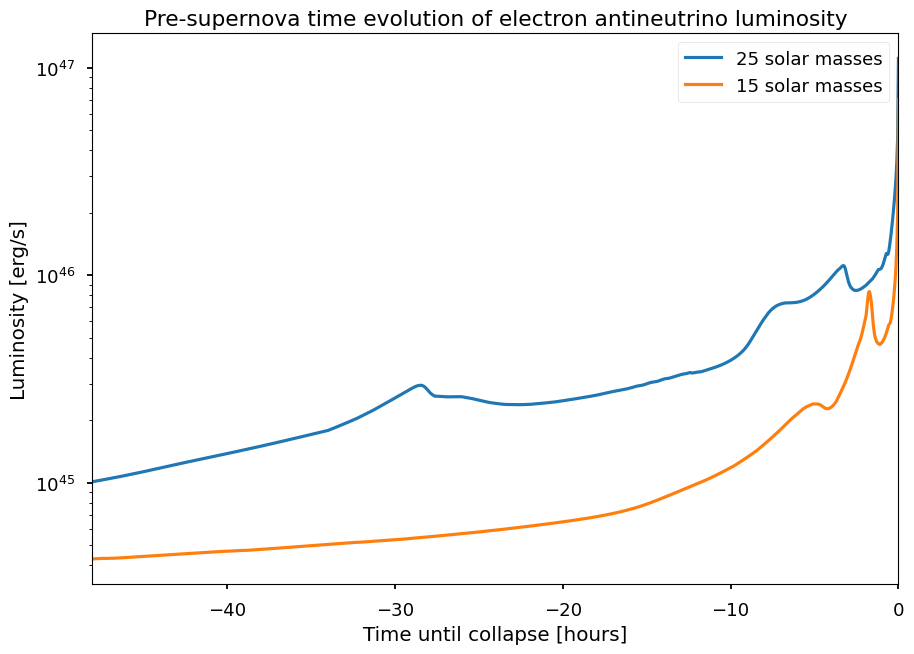

In [33]:
#IDA Figure 2 (top) from KamLAND paper
model_25 = presn.Odrzywolek_2010('../../models/presn-models/Odrzywolek_2010/s25_nuebar_data.txt')
model_15 = presn.Odrzywolek_2010('../../models/presn-models/Odrzywolek_2010/s15_nuebar_data.txt')
E_3 = np.linspace(0,20,201) * u.MeV #energy points for integration

width_bins = (20/201)
luminosity_time = np.linspace(-172800,-1,1000)<<u.s

luminosity_values_tot_25 = []
luminosity_values_tot_15 = []
spectra_3 = []
tot_luminosity=0

for t in luminosity_time:
    spectra = model_25.get_initial_spectra(t, E_3, flavors = [Flavor.NU_E_BAR])
    differential_luminosity = (spectra.get(2)[0] * (E_3)).value * 1.602 * 10**-6
    luminosity = differential_luminosity * width_bins
    tot_luminosity = np.sum(luminosity)
    luminosity_values_tot_25.append(tot_luminosity)

for t in luminosity_time:
    spectra = model_15.get_initial_spectra(t, E_3, flavors = [Flavor.NU_E_BAR])
    differential_luminosity = (spectra.get(2)[0] * (E_3)).value * 1.602 * 10**-6
    luminosity = differential_luminosity * width_bins
    tot_luminosity = np.sum(luminosity)
    luminosity_values_tot_15.append(tot_luminosity)


luminosity_time_3 = luminosity_time.to(u.hour)
plt.plot(luminosity_time_3,luminosity_values_tot_25, label = '25 solar masses')
plt.plot(luminosity_time_3,luminosity_values_tot_15, label = '15 solar masses')
plt.yscale("log")
plt.legend()
plt.title('Pre-supernova time evolution of electron antineutrino luminosity')
plt.xlim(-48,0)
plt.ylabel("Luminosity [erg/s]")
plt.xlabel("Time until collapse [hours]")
plt.show()

### #2 Plot Fig. 2 (middle) from KamLAND paper - average electron-anti neutrino energy
Decription: Time evolution of averaged anti-electron neutrino energy

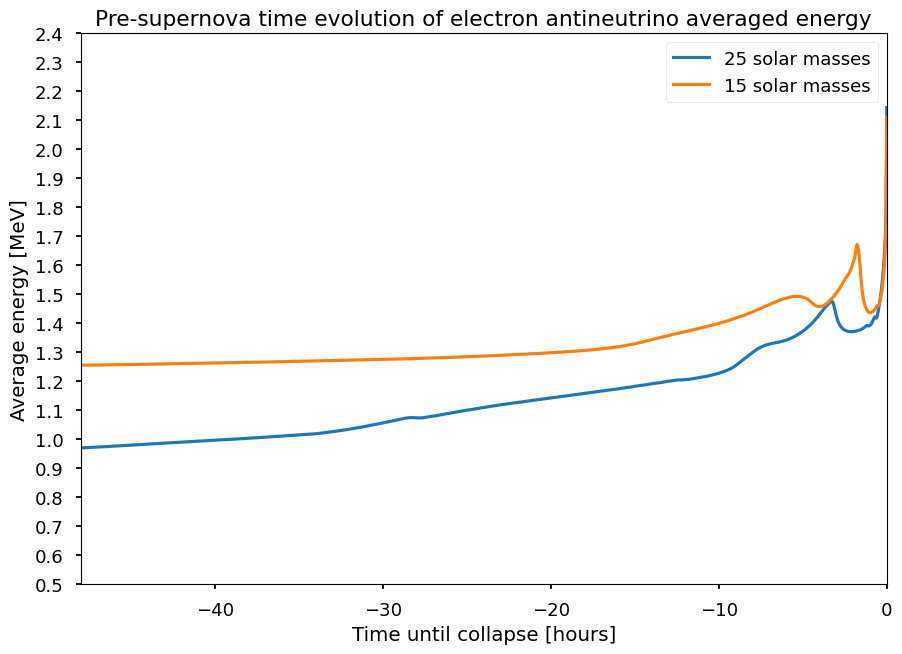

In [34]:
#IDA Figure 2 (middle) from KamLAND paper
#model_15 = presn.Odrzywolek_2010('../../models/presn-models/Odrzywolek_2010/s15_nuebar_data.txt')
E_3 = np.linspace(0,20,201) * u.MeV #energy points for integration

width_bins = (20/200)
luminosity_time = np.linspace(-172800,-1,1000)<<u.s

average_energy_25 = []
average_energy_15 = []


for t in luminosity_time:
    spectra = model_25.get_initial_spectra(t, E_3, flavors = [Flavor.NU_E_BAR])
    for energy in E_3:
        energy_f = (spectra.get(2)[0] * (E_3)).value
    average_energy = np.sum(energy_f) / np.sum(spectra.get(2)[0].value)
    average_energy_25.append(average_energy)


for t in luminosity_time:
    spectra = model_15.get_initial_spectra(t, E_3, flavors = [Flavor.NU_E_BAR])
    for energy in E_3:
        energy_f = (spectra.get(2)[0] * (E_3)).value
    average_energy = np.sum(energy_f) / np.sum(spectra.get(2)[0].value)
    average_energy_15.append(average_energy)



luminosity_time_3 = luminosity_time.to(u.hour)
plt.plot(luminosity_time_3, average_energy_25, label = '25 solar masses')
plt.plot(luminosity_time_3, average_energy_15, label = '15 solar masses')
#plt.yscale("log")
plt.legend()
plt.title('Pre-supernova time evolution of electron antineutrino averaged energy')
plt.xlim(-48,0)
plt.yticks(np.arange(0.5, 2.5, 0.1))
plt.ylabel("Average energy [MeV]")
plt.xlabel("Time until collapse [hours]")
plt.show()

### #3 Plot Fig. 4 (middle) from KamLAND paper - PreSN integrated energy spectrum 48 h before collapse

In [15]:
#Copied from snowglobes usage notebook
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from snewpy import snowglobes

SNOwGLoBES_path = None  # to use custom SNOwGLoBES detector/channel/smearing files, set SNOwGLoBES directory
SNEWPY_models_base = "../../models/"  # directory containing SNEWPY models

In [16]:
#General parameters
# set distance in kpc
distance = 0.2

# set SNOwGLoBES detector to use
detector = "scint20kt"

# set SNEWPY model type and filename
modeltype = 'Odrzywolek_2010'

# set desired flavor transformation
transformation = 'AdiabaticMSW_NMO'
transformation_INV = 'AdiabaticMSW_IMO'

# Option 2 - specify single tstart and tend, this makes 1 fluence file integrated over the window
tstart = -172800 * u.s
tend = 0.8 * u.s

In [17]:
#15 solar masses, normal mass ordering
model = 's15_nuebar_data'
modelfile = SNEWPY_models_base + "presn-models/" + modeltype + "/" + model + '.txt'
outfile = modeltype+"_"+model+"_"+transformation

In [18]:
#25 solar masses, normal mass ordering
model_25 = 's25_nuebar_data'
modelfile_25 = SNEWPY_models_base + "presn-models/" + modeltype + "/" + model_25 + '.txt'
outfile_25 = modeltype+"_"+model_25+"_"+transformation

In [19]:
#15 solar masses, inverted mass ordering
model = 's15_nuebar_data'
modelfile = SNEWPY_models_base + "presn-models/" + modeltype + "/" + model + '.txt'
outfile_INV = modeltype+"_"+model+"_"+transformation_INV

In [20]:
#25 solar masses, inverted mass ordering
model_25 = 's25_nuebar_data'
modelfile_25 = SNEWPY_models_base + "presn-models/" + modeltype + "/" + model_25 + '.txt'
outfile_25_INV = modeltype+"_"+model_25+"_"+transformation_INV

In [21]:
#Generate 25 solar masses, inverted
print("Preparing fluences ...")
tarredfile_25_INV = snowglobes.generate_fluence(modelfile_25, modeltype, transformation_INV, distance, outfile_25_INV, tstart, tend)

# Next, we run SNOwGLoBES. This will loop over all the fluence files in `tarredfile`.
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile_25_INV, detector_input=detector)

# Finally, we collate SNOwGLoBES’ results into a dictionary
print("Collating results ...")
tables_25_INV = snowglobes.collate(SNOwGLoBES_path, tarredfile_25_INV, skip_plots=True)

Preparing fluences ...
Running SNOwGLoBES ...
Using snowglobes_data module ...


/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nuebar_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:16

Collating results ...


In [22]:
#Generate 15 solar masses, inverted
print("Preparing fluences ...")
tarredfile_INV = snowglobes.generate_fluence(modelfile, modeltype, transformation_INV, distance, outfile_INV, tstart, tend)

# Next, we run SNOwGLoBES. This will loop over all the fluence files in `tarredfile`.
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile_INV, detector_input=detector)

# Finally, we collate SNOwGLoBES’ results into a dictionary
print("Collating results ...")
tables_INV = snowglobes.collate(SNOwGLoBES_path, tarredfile_INV, skip_plots=True)

Preparing fluences ...
Running SNOwGLoBES ...
Using snowglobes_data module ...


/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nuebar_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:16

Collating results ...


In [23]:
#Generate 25 solar masses, normal
print("Preparing fluences ...")
tarredfile_25 = snowglobes.generate_fluence(modelfile_25, modeltype, transformation, distance, outfile_25, tstart, tend)

# Next, we run SNOwGLoBES. This will loop over all the fluence files in `tarredfile`.
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile_25, detector_input=detector)

# Finally, we collate SNOwGLoBES’ results into a dictionary
print("Collating results ...")
tables_25 = snowglobes.collate(SNOwGLoBES_path, tarredfile_25, skip_plots=True)

Preparing fluences ...
Running SNOwGLoBES ...
Using snowglobes_data module ...


/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nuebar_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:16

Collating results ...


In [24]:
#Generate 15 solar masses, normal
print("Preparing fluences ...")
tarredfile = snowglobes.generate_fluence(modelfile, modeltype, transformation, distance, outfile, tstart, tend)

# Next, we run SNOwGLoBES. This will loop over all the fluence files in `tarredfile`.
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile, detector_input=detector)

# Finally, we collate SNOwGLoBES’ results into a dictionary
print("Collating results ...")
tables = snowglobes.collate(SNOwGLoBES_path, tarredfile, skip_plots=True)

Preparing fluences ...
Running SNOwGLoBES ...
Using snowglobes_data module ...


/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nuebar_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:16

Collating results ...


In [25]:
#Find keys
print(list(tables.keys()))

['scint20kt', 'Collated_Odrzywolek_2010_s15_nuebar_data_AdiabaticMSW_NMO_scint20kt_events_smeared_weighted.dat', 'Collated_Odrzywolek_2010_s15_nuebar_data_AdiabaticMSW_NMO_scint20kt_events_unsmeared_weighted.dat']


In [26]:
#Use this code to print out events in each energybin for a key
key = 'Collated_Odrzywolek_2010_s15_nuebar_data_AdiabaticMSW_NMO_scint20kt_events_smeared_weighted.dat'

print(f"Energy bins (in MeV):\n{tables[key]['data'][0][:12]}")

for i, channel in enumerate(tables[key]['header'].split()[1:]):

    print(f"Number of {channel} events in those energy bins:\n{tables[key]['data'][i+1][:12]}")

Energy bins (in MeV):
[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
Number of ibd events in those energy bins:
[  0.           0.         106.64999935 196.60997974 191.50085925
 138.73458975  85.39127823  47.65270037  24.90121     12.40059169
   5.99641111   2.83326325]
Number of nue_C12 events in those energy bins:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.82319981e-15 6.26511798e-13 3.74391690e-12]
Number of nue_C13 events in those energy bins:
[3.70902729e-02 2.68966489e-02 1.63620477e-02 9.13178880e-03
 4.76981742e-03 2.41205125e-03 1.17688367e-03 5.65802150e-04
 2.66123235e-04 1.24389113e-04 5.73604839e-05 2.64198484e-05]
Number of nuebar_C12 events in those energy bins:
[0.00000000e+00 0.00000000e+00 4.38761013e-12 4.53843466e-11
 7.24911252e-11 5.90545490e-11 3.89507308e-11 2.35520792e-11
 1.35148346e-11 7.80452813e-12 3.04712142e-12 2.94120398e-13]
Number of nc events in those 

In [27]:
#KEYS
key = 'Collated_Odrzywolek_2010_s15_nuebar_data_AdiabaticMSW_NMO_scint20kt_events_smeared_weighted.dat'
key_25 = 'Collated_Odrzywolek_2010_s25_nuebar_data_AdiabaticMSW_NMO_scint20kt_events_smeared_weighted.dat'
key_INV = 'Collated_Odrzywolek_2010_s15_nuebar_data_AdiabaticMSW_IMO_scint20kt_events_smeared_weighted.dat'
key_25_INV = 'Collated_Odrzywolek_2010_s25_nuebar_data_AdiabaticMSW_IMO_scint20kt_events_smeared_weighted.dat'

Text(0, 0.5, 'dN/dE')

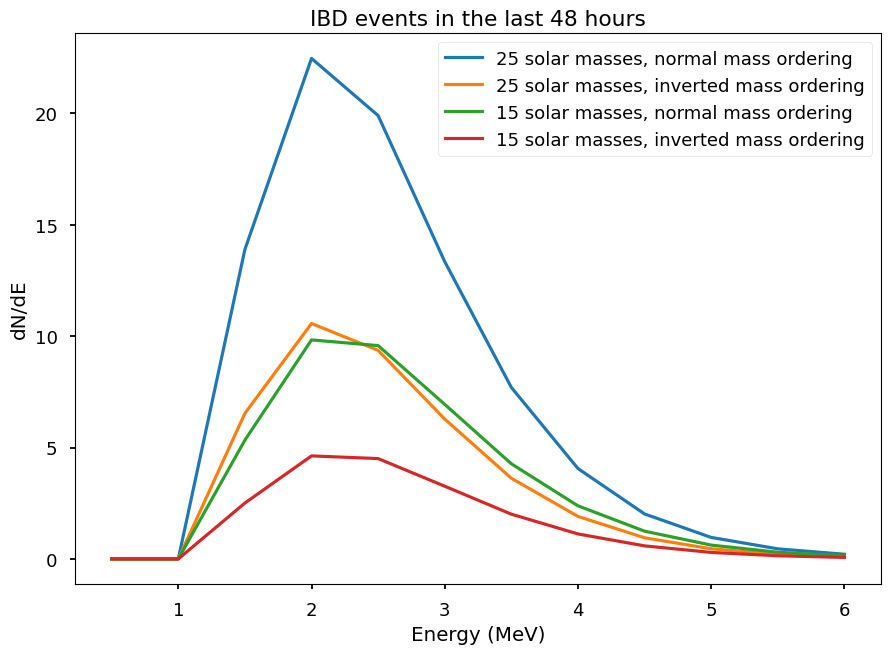

In [28]:
#25 solar masses normal
table_25 = tables_25[key_25]['data']

energy_bins_25 = table_25[0][:12] 
ibd_channel_idx_25 = None
for idx, channel in enumerate(tables_25[key_25]['header'].split()[1:]):
    if channel == 'ibd':
        ibd_channel_idx_25 = idx + 1
        break

events_ibd_25 = table_25[ibd_channel_idx_25][:12]
events25_divided_by_20 = np.array(events_ibd_25) / 20.0

#25 solar masses inverted
table_25_INV = tables_25_INV[key_25_INV]['data']

energy_bins_25_INV = table_25_INV[0][:12] 
ibd_channel_idx_25_INV = None
for idx, channel in enumerate(tables_25_INV[key_25_INV]['header'].split()[1:]):
    if channel == 'ibd':
        ibd_channel_idx_25_INV = idx + 1
        break

events_ibd_25_INV = table_25_INV[ibd_channel_idx_25_INV][:12]
events25_INV_divided_by_20 = np.array(events_ibd_25_INV)/ 20.0

#15 solar masses inverted
table_INV = tables_INV[key_INV]['data']

energy_bins_INV = table_INV[0][:12] 
ibd_channel_idx_INV = None
for idx, channel in enumerate(tables_INV[key_INV]['header'].split()[1:]):
    if channel == 'ibd':
        ibd_channel_idx_INV = idx + 1
        break

events_ibd_INV = table_INV[ibd_channel_idx_INV][:12]
events_INV_divided_by_20 = np.array(events_ibd_INV) / 20.0

#15 solar masses normal
table = tables[key]['data']

energy_bins = table[0][:12] 
ibd_channel_idx = None
for idx, channel in enumerate(tables[key]['header'].split()[1:]):
    if channel == 'ibd':
        ibd_channel_idx = idx + 1
        break

events_ibd = table[ibd_channel_idx][:12]
events_divided_by_20 = np.array(events_ibd)/ 20.0

plt.title('IBD events in the last 48 hours')
plt.plot(energy_bins, events25_divided_by_20, label = '25 solar masses, normal mass ordering')
plt.plot(energy_bins, events25_INV_divided_by_20, label = '25 solar masses, inverted mass ordering')
plt.plot(energy_bins, events_divided_by_20, label = '15 solar masses, normal mass ordering')
plt.plot(energy_bins, events_INV_divided_by_20, label = '15 solar masses, inverted mass ordering')
plt.legend()
plt.xlabel('Energy (MeV)')
plt.ylabel('dN/dE')